In [1]:
import os 
import ipyvolume as ipv
from tyssue import HistoryHdf5
from tyssue.draw import browse_history
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [5]:
history = HistoryHdf5.from_archive(
    '/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20191210-homogenous_Vp_Kp_P0_A0/0.0001_V_10.0_k_4_P0A0_0/out.hf5'
    )


specs = {
    "face": {
        "visible": True,
        "color":'white',
        #"color": lambda sheet : sheet.face_df['ablate'],
        "colormap": 'Blues',
        "alpha": 0.2
    },
    
}


browse_history(history, coords=['z', 'x', 'y'], **specs)
ipv.style.use("dark")
ipv.style.box_off()
ipv.pylab.style.axes_off()

/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


interactive(children=(IntSlider(value=0, description='i', max=149), Output()), _dom_classes=('widget-interact'…

In [6]:
sheet = history.retrieve(6)
sheet.edge_df[sheet.edge_df.weight==0].face


AttributeError: 'DataFrame' object has no attribute 'weight'

In [7]:
sheet.face_df[sheet.face_df.is_mesoderm==1]

,x,y,z,num_sides,area,perimeter,is_alive,face_o,opposite,height,...,contractility,id,fold,apoptosis,current_traction,radial_tension,prefered_perimeter,perimeter_elasticity,is_mesoderm,time
330,4.612561,6.78192,-3.791292,7,39.824007,25.428359,1.0,330.0,-1.0,9.803408,...,1.52,330,0,0,0.0,50.0,25.461516,10.0,1,6.0


In [54]:
t_before_cut = 5
t_after_cut = 6

result = pd.DataFrame()
for f in list_file:
    history = HistoryHdf5.from_archive(os.path.join(dirname, f))
    
    # define which vertice needs to followed the displacement 
    sheet = history.retrieve(t_after_cut)
    
    edge_cut = sheet.edge_df[sheet.edge_df.ablate==1].index.to_numpy()[0]
    vertice_to_follow = []
    list_vert = (sheet.edge_df[sheet.edge_df.ablate==1]['srce']).to_numpy()
    for v in list_vert:
        vertice_to_follow.append(v)
    
    
    # Information before cut
    sheet = history.retrieve(t_before_cut)
    pos_before_cut = sheet.vert_df.loc[vertice_to_follow][['x','y','z']]
    pos_before_cut.columns=['x0', 'y0', 'z0']
    
    # normalisation par rapport au centre de la face
    pos_before_cut['x_face0'] = pos_before_cut.x0 - sheet.face_df.loc[face_cut].x
    pos_before_cut['y_face0'] = pos_before_cut.y0 - sheet.face_df.loc[face_cut].y
    pos_before_cut['z_face0'] = pos_before_cut.z0 - sheet.face_df.loc[face_cut].z
    
    # Information after cut
    sheet = history.retrieve(t_after_cut)
    
    pos_after_cut = sheet.vert_df.loc[vertice_to_follow][['x','y','z']]
    pos_after_cut.columns=['x1', 'y1', 'z1']
    pos_after_cut['x_face1'] = pos_after_cut.x1 - sheet.face_df.loc[face_cut].x
    pos_after_cut['y_face1'] = pos_after_cut.y1 - sheet.face_df.loc[face_cut].y
    pos_after_cut['z_face1'] = pos_after_cut.z1 - sheet.face_df.loc[face_cut].z

    
    
    result_temp = pd.concat([pos_before_cut, pos_after_cut], axis = 1)
    result_temp['simulation'] = f.split('.')[2][-1]

    result = pd.concat([result, result_temp], axis = 0)
    

result['distance'] = np.sqrt((result.x_face0 - result.x_face1)**2
                   + (result.y_face0 - result.y_face1)**2
                   +(result.z_face0 - result.z_face1)**2
                  )

result['angle0'] = np.abs(np.arctan(result.x_face0/result.z_face0)*180/np.pi)
result['angle1'] = np.abs(np.arctan(result.x_face1/result.z_face1)*180/np.pi)



In [55]:
result_polarized = result.copy()

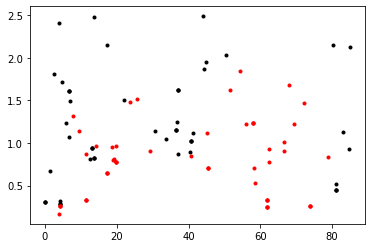

In [56]:
plt.plot(np.mean(result_homogenous[['angle0','angle1']], axis=1), result_homogenous['distance'], '.', color='black')
plt.plot(np.mean(result_polarized[['angle0','angle1']], axis=1), result_polarized['distance'], '.', color='red')

(array([16.,  0.,  4., 10.,  9.,  3.,  6.,  2.,  2.,  2.]),
 array([0.16811395, 0.33565138, 0.50318881, 0.67072624, 0.83826367,
        1.0058011 , 1.17333853, 1.34087596, 1.50841339, 1.67595083,
        1.84348826]),
 <a list of 10 Patch objects>)

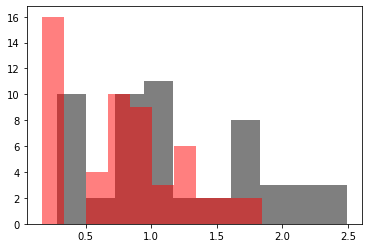

In [57]:
plt.hist( result_homogenous['distance'], color='black', alpha =0.5)
plt.hist( result_polarized['distance'],  color='red', alpha =0.5)

In [70]:
from tyssue import Sheet
def face_centered_patch(sheet, face, neighbour_order, rotation=None):

    faces = pd.Series(face).append(
        sheet.get_neighborhood(face, order=neighbour_order)['face'])
    
    edges = sheet.edge_df[sheet.edge_df['face'].isin(faces)]

    vertices = sheet.vert_df.loc[set(edges['srce'])]
    pos = vertices[sheet.coords].values - vertices[sheet.coords].mean(axis=0).values[None, :]
    if rotation is None: 
        u, v, rotation = np.linalg.svd(pos, full_matrices=False)
       
    rot_pos = pd.DataFrame(np.dot(pos, rotation.T), 
                           index=vertices.index,
                           columns=sheet.coords)

    patch_dset = {'vert': rot_pos,
                  'face': sheet.face_df.loc[faces].copy(),
                  'edge': edges.copy()}

    patch = Sheet('patch', patch_dset, sheet.specs)
    patch.reset_index()
    return patch, rotation

from tyssue.draw import sheet_view



def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color':'k',
            'width':sheet.edge_df['weight']
            #'color': sheet.edge_df['stress'],
            #"colormap":'bwr',
            #'color_range':(-20,20)
        },
        'face': {
            'visible': True,
            'color':sheet.face_df.apoptosis+sheet.face_df.fold,
            'colormap': 'Blues',
            'alpha':0.5

        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs

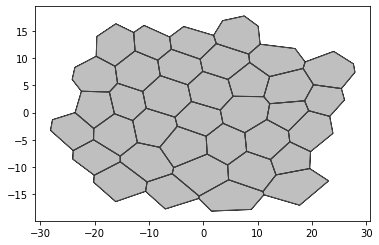

In [77]:
from tyssue import SheetGeometry as geom
sheet = history.retrieve(5)
#face = sheet.face_df[sheet.face_df.ablate==1].index.to_numpy()[0]
sheet_, rotation = face_centered_patch(sheet, 450, 3)
geom.update_all(sheet_)


fig, ax = sheet_view(sheet_, mode="2D", **draw_specs(sheet_))

In [78]:
from tyssue import SheetGeometry as geom

sheet = history.retrieve(7)
#face = sheet.face_df[sheet.face_df.ablate==1].index.to_numpy()[0]
sheet_,rotation = face_centered_patch(sheet, 450, 3, rotation=rotation)
geom.update_all(sheet_)


fig, ax = sheet_view(sheet_, mode="2D", **draw_specs(sheet_), ax = ax)

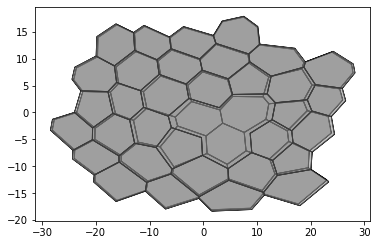

In [79]:
#nonpolarise 
fig

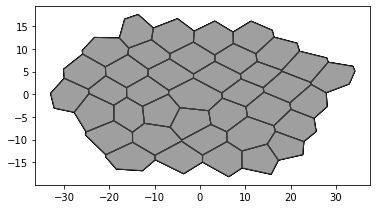

In [80]:
#polarize
fig2

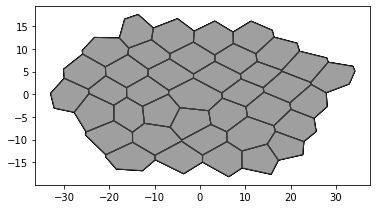

In [81]:
from tyssue import SheetGeometry as geom
sheet = history.retrieve(5)
#face = sheet.face_df[sheet.face_df.ablate==1].index.to_numpy()[0]
sheet_, rotation = face_centered_patch(sheet, 1189, 3)
geom.update_all(sheet_)


fig2, ax = sheet_view(sheet_, mode="2D", **draw_specs(sheet_))
from tyssue import SheetGeometry as geom

sheet = history.retrieve(6)
#face = sheet.face_df[sheet.face_df.ablate==1].index.to_numpy()[0]
sheet_,rotation = face_centered_patch(sheet, 1189, 3, rotation=rotation)
geom.update_all(sheet_)


fig2, ax = sheet_view(sheet_, mode="2D", **draw_specs(sheet_), ax = ax)